Questions:
- android: The seconds_elapsed of sensors are different. 
    - Shall we at first use only the data from iphone?
    - how to deal with the negative values?
    

Data formatting:
- add columns: user (OC,WZ,...), Activity (Velo, joggen,...)
- delete sensor = 'meta data' (version,device name,recording time, platform, appVersion,device id,...), because 
    - they are not helpful for modelling
    - we can always call back the information as long as we know the 'user'
    - take the 
   

## Challenge of deep learning 

### Sensor (by Sensor Logger APP)

- 11 Sensors data are collected: **'TotalAcceleration'** (only in android), 'Barometer', 'Location', 'Orientation', '**Magnetometer**', 'GyroscopeUncalibrated', 'MagnetometerUncalibrated', '**Accelerometer**', 'AccelerometerUncalibrated', '**Gyroscope**', '**Gravity**'

- We should **use only the calibrated data.** Sensor Logger gives you the option to log raw, uncalibrated data from the accelerometer, gyroscope and magnetometer. Calibrated data is always logged. The raw stream is useful for performing lower-level post-processing or custom sensor fusion. If in doubt, **always use the calibrated version** unless you have a good reason not to. https://github.com/tszheichoi/awesome-sensor-logger#when-to-use-uncalibrated-data

**Info from App**
- Device Acceleration (Accelerometer; Raw & Calibrated)
- **Gravity Vector** (Accelerometer)
- Device **Rotation** Rate (**Gyroscope**; Raw & Calibrated)
- Device Orientation (Gyroscope)
- Magnetic Heading (**Magnetometer**; Raw & Calibrated)
- Barometric Altitude (Barometer)
- GPS Coordinate, Altitude, Speed & Heading

**Selection:**
- **acceleration/Beschleunigungs:** 
    - **Accelerometer**: measures **linear acceleration** (?) and the vibration. Units are **meters per second squared (𝑚/𝑠2)** or **G- forces (𝑔)**.
    - **Gravity**: 
- **rotation sensor:** 
    - **Gyroscope**: uses Earth's gravity to help determine orientation. Gyro sensors are devices that sense **angular velocity** which is the change in rotational angle per unit of time. Angular velocity is generally expressed in deg/s (**degrees per second**).
- **magnetometer:** 
    - **Magnetometer**: is generally **assembled with an accelerometer and a gyroscope** into an **inertial unit**. It measures the change of a magnetic field at a particular location. The measurement units are Tesla (𝑇 ), and the sampling rate is from tens to hundreds of Hz.

### 10 User

### Activity 
- laufen
- joggen
- treppelaufen
- velofahre
- stehen
- sitzen

### Data size
- 10 records per user per activity
- d.h. 100 records for each activity, 60 records from each user 


In [346]:
import json
import glob
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None) 

## 1. load data
### 1.1 load csv files and json file

In [137]:
sensor_lst = ['Magnetometer', 'Accelerometer', 'Gyroscope', 'Gravity'] # sensors we want to select   

In [138]:
# long tables and visual
# read one record in csv files form, and join the selected sensors in one dataframe

def read_csvs(path, activity_type, userID):
    df_append = pd.DataFrame()  # an empty dataframe to append the selected csv files
    path = '../Daten/01_Pixel6-2023-02-24_17-31-22' # folder which includes around 12 csv files of one record
    csv_files = glob.glob(os.path.join(path, "*.csv")) # a list include the exact path of each csv file -> for pd.read_csv()
    
    for i in range(len(csv_files)):
        file_path = csv_files[i] # file path of the i-th csv file
        sensor_name = os.path.splitext(os.path.basename(file_path))[0] # extract the file name as sensor name
        if sensor_name in sensor_lst: # only append the selected files
            df_temp = pd.read_csv(csv_files[i])
            df_temp['sensor'] = sensor_name
            df_temp['activity'] = activity_type
            df_temp['userID'] = userID
            
    # concat the non-empty DataFrame here
        df_append = pd.concat([df_append, df_temp], ignore_index=True, sort=False)
        df_append = df_append[['sensor', 'time', 'seconds_elapsed', 'x', 'y', 'z', 'activity',
       'userID']]
    return df_append

# read one record in json form
def read_json(path, activity_type, userID):
    df = pd.read_json(path)
    # only keep the selected sensors, and drop the all-nan columns
    df = df[df['sensor'].isin(sensor_lst)].dropna(how='all',axis=1) 
    df['activity'] = activity_type
    df['userID'] = userID
    df = df[['sensor', 'time', 'seconds_elapsed', 'x', 'y', 'z', 'activity',
       'userID']] # reorder columns
    return df

# visualize sensor data by time
def vis_all_sensors(df):
    sensor_lst = df['sensor'].unique()
    for i in range(len(sensor_lst)):
        sensor_ = sensor_lst[i]
        df_temp = df[df['sensor']== sensor_]
        df_temp.set_index('seconds_elapsed', inplace=True)
        # visulaization
        df_temp[['x', 'y', 'z']].plot(title=sensor_, color = ['skyblue', 'orange', 'green'],figsize=(15,3))
        plt.show()

In [ ]:
# path = '../Daten/01_Pixel6-2023-02-24_17-31-22'

In [242]:
# wide tables and visual
# read one record in csv files form, and join the selected sensors in one dataframe

def read_csvs(path, activity_type, userID):
    df_append = pd.DataFrame()  # an empty dataframe to append the selected csv files
     # folder which includes around 12 csv files of one record
    csv_files = glob.glob(os.path.join(path, "*.csv")) # a list include the exact path of each csv file -> for pd.read_csv()
    
    for i in range(len(csv_files)):
        file_path = csv_files[i] # file path of the i-th csv file
        sensor_name = os.path.splitext(os.path.basename(file_path))[0] # extract the file name as sensor name
        if sensor_name in sensor_lst: # only append the selected files
            df_temp = pd.read_csv(csv_files[i])
            df_temp.columns = [f'{col}_{sensor_name}' for col in df_temp.columns]
            df_temp['activity'] = activity_type
            df_temp['userID'] = userID
                      
    # concat the non-empty DataFrame here
        df_append = pd.concat([df_append, df_temp], ignore_index=True, sort=False)
        df_append = df_append[['sensor', 'time', 'seconds_elapsed', 'x', 'y', 'z', 'activity',
       'userID']]
    return df_append

# read one record in json form
def read_json(path, activity_type, userID):
    df = pd.read_json(path)
    df_append = pd.DataFrame()
    # only keep the selected sensors, and drop the all-nan columns
    df = df[df['sensor'].isin(sensor_lst)].dropna(how='all',axis=1) 
    #df['seconds_elapsed'] = df['seconds_elapsed'].round(3)
    df['seconds_elapsed'] = np.floor(df['seconds_elapsed'] *100)/100


    for i in range(len(sensor_lst)):
        sensor_ = sensor_lst[i]
        df_temp = df[df['sensor']==sensor_][['seconds_elapsed', 'x', 'y', 'z']].set_index('seconds_elapsed')
        df_temp.columns = [f'{col}_{sensor_}' for col in df_temp.columns]
        df_append = pd.concat([df_append, df_temp], axis=1)
        
    
    #df_append = df_append.reset_index(drop=False)
    #df_append['seconds_elapsed'] = np.floor(df_append['seconds_elapsed']*100)/100
    #df_append = df_append.set_index('seconds_elapsed')
    
    #df_append = df_append.dropna(how='any',axis=0) 
    df_append['activity'] = activity_type
    df_append['userID'] = userID
    df_append = df_append.dropna(how='all',axis=1)
    #df = df[['sensor', 'time', 'seconds_elapsed', 'x', 'y', 'z', 'activity','userID']] # reorder columns
    return df_append

# visualize sensor data by time
def vis_all_sensors(df):
    col_lst = df.columns[:-2]
    for i in range(int(len(col_lst)/3)):
        col_ = col_lst[3*i:(3*i+3)]
        df[col_].plot(title=f'{df[df.columns[-2]].unique()[0]}_{df[df.columns[-1]].unique()[0]}',figsize=(15,3))
        plt.show()
        
# (np.median(df['seconds_elapsed'])-second_/2 
# (np.median(df['seconds_elapsed'])+second_/2
def time_win(df,min_time,nr):
    # select time window
    # second_: how many seconds will be kept in each dataframe
    df = df.reset_index(drop=False)
    df = df[df['seconds_elapsed'] >= min_time]
    return df.head(nr).set_index('seconds_elapsed')

In [207]:
lauf = read_csvs('../Daten/01_Pixel6-2023-02-24_17-31-22','laufen','FB')
lauf

UnboundLocalError: local variable 'df_temp' referenced before assignment

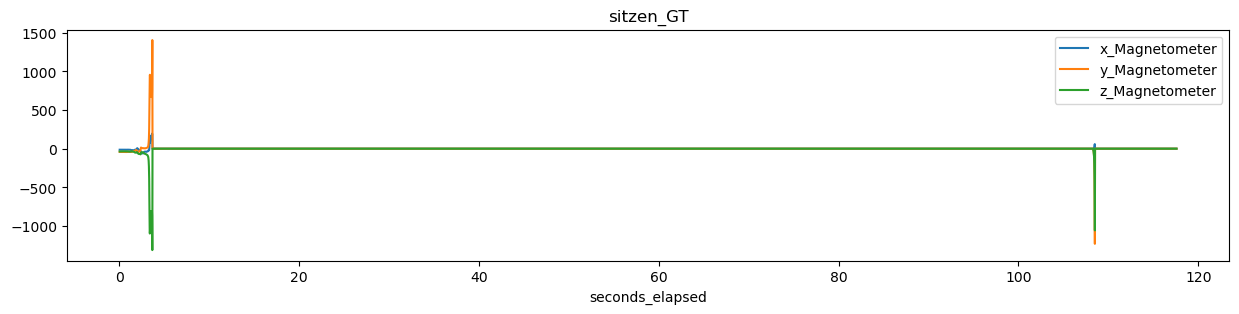

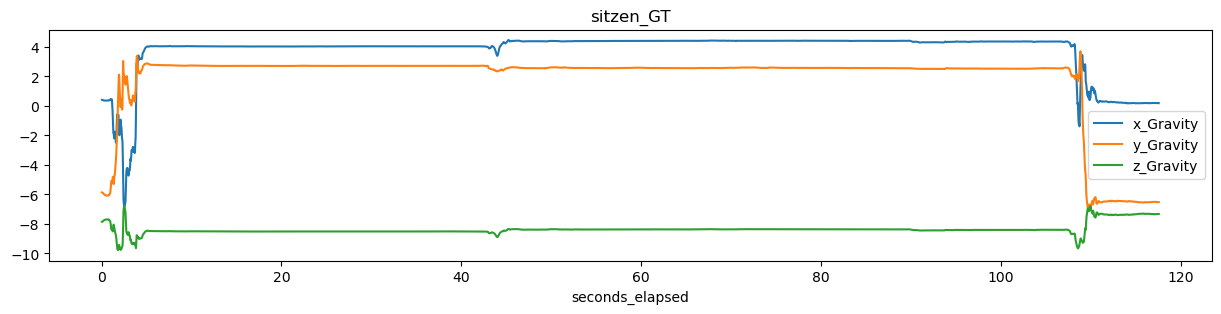

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
0.04                 -13.398655      -41.990791      -35.891083   
0.05                 -13.377613      -42.020042      -35.894905   
0.06                 -13.356449      -42.025887      -35.860474   
0.07                 -13.333351      -42.300781      -35.986786   
0.08                 -13.382448      -42.496414      -35.868073   
...                         ...             ...             ...   
117.54                 0.000000        0.000000        0.000000   
117.55                 0.000000        0.000000        0.000000   
117.56                 0.000000        0.000000        0.000000   
117.57                 0.000000        0.000000        0.000000   
117.58                 0.000000        0.000000        0.000000   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
0.04                   -0.105673         0.146821        -0.226817   
0.05                   -0.117292         0.097771        -0.089536   
0.06                   -0.050429         0.038823        -0.004310   
0.07                    0.022535         0.012540        -0.002625   
0.08                    0.073155        -0.050219        -0.053417   
...                          ...              ...              ...   
117.54                 -0.074546        -0.042015        -0.030617   
117.55                 -0.087041        -0.018097        -0.022623   
117.56                 -0.079774         0.045264        -0.058854   
117.57                 -0.044924         0.047037        -0.004624   
117.58                 -0.008192         0.048402         0.020047   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
0.04                0.082644    -0.004766     0.017370   0.417219  -5.860284   
0.05                0.090226    -0.016313     0.000661   0.415968  -5.867498   
0.06                0.073736    -0.032206    -0.010252   0.414497  -5.874091   
0.07                0.042741    -0.040554    -0.010479   0.412312  -5.878783   
0.08                0.017895    -0.045215    -0.004102   0.409426  -5.881266   
...                      ...          ...          ...        ...        ...   
117.54             -0.004671    -0.042029    -0.010025   0.197698  -6.519893   
117.55              0.001428    -0.035910    -0.015557   0.195529  -6.519720   
117.56              0.005074    -0.015327    -0.010826   0.194695  -6.519933   
117.57              0.000613    -0.011072    -0.006577   0.194412  -6.520210   
117.58             -0.007306    -0.004512     0.004057   0.193892  -6.520078   

                 z_Gravity activity userID  
seconds_elapsed                             
0.04             -7.851967   sitzen     GT  
0.05             -7.846644   sitzen     GT  
0.06             -7.841787   sitzen     GT  
0.07             -7.838385   sitzen     GT  
0.08             -7.836674   sitzen     GT  
...                    ...      ...    ...  
117.54           -7.322724   sitzen     GT  
117.55           -7.322937   sitzen     GT  
117.56           -7.322769   sitzen     GT  
117.57           -7.322531   sitzen     GT  
117.58           -7.322661   sitzen     GT  

[11818 rows x 14 columns]

In [244]:
path = '../Daten/01_iPhone13ProMax-2023-02-23_15-26-55.json'
sitz = read_json(path,'sitzen','GT')
vis_all_sensors(sitz)
sitz

In [245]:
time_win(sitz,25,800)

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
25.00                       0.0             0.0             0.0   
25.01                       0.0             0.0             0.0   
25.02                       0.0             0.0             0.0   
25.03                       0.0             0.0             0.0   
25.04                       0.0             0.0             0.0   
...                         ...             ...             ...   
32.90                       0.0             0.0             0.0   
32.91                       0.0             0.0             0.0   
32.92                       0.0             0.0             0.0   
32.93                       0.0             0.0             0.0   
32.94                       0.0             0.0             0.0   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
25.00                  -0.027396        -0.010727        -0.009320   
25.01                  -0.007640        -0.008212        -0.020573   
25.02                  -0.014998        -0.018595        -0.006855   
25.03                  -0.000438        -0.012365        -0.003000   
25.04                  -0.014897        -0.007669        -0.010359   
...                          ...              ...              ...   
32.90                  -0.032344        -0.025415        -0.008519   
32.91                  -0.022620        -0.027699        -0.020583   
32.92                  -0.012102        -0.021699        -0.006271   
32.93                  -0.011130        -0.022911        -0.012304   
32.94                  -0.018402        -0.011716        -0.026650   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
25.00               0.002950     0.002298     0.001764   4.037834   2.720364   
25.01              -0.001757     0.003660    -0.001407   4.037979   2.720244   
25.02              -0.004251     0.003579     0.001187   4.038154   2.720602   
25.03              -0.000934     0.000086     0.001655   4.038408   2.720806   
25.04              -0.001729     0.001395     0.002770   4.038502   2.720748   
...                      ...          ...          ...        ...        ...   
32.90              -0.000568    -0.001698    -0.000141   4.047420   2.718593   
32.91              -0.001679    -0.002482     0.001149   4.047273   2.718632   
32.92              -0.000885    -0.001890    -0.000821   4.047080   2.718618   
32.93              -0.000724    -0.002088     0.000042   4.046857   2.718632   
32.94               0.001158    -0.000617    -0.000519   4.046796   2.718660   

                 z_Gravity activity userID  
seconds_elapsed                             
25.00            -8.512691   sitzen     GT  
25.01            -8.512661   sitzen     GT  
25.02            -8.512463   sitzen     GT  
25.03            -8.512277   sitzen     GT  
25.04            -8.512251   sitzen     GT  
...                    ...      ...    ...  
32.90            -8.508703   sitzen     GT  
32.91            -8.508761   sitzen     GT  
32.92            -8.508857   sitzen     GT  
32.93            -8.508959   sitzen     GT  
32.94            -8.508979   sitzen     GT  

[800 rows x 14 columns]

In [203]:
#samsung von Ben
velo = read_json('../Daten/01_SamsungA22-2023-02-27_15-37-24.json', 'velo', 'BT')
vis_all_sensors(velo)
velo

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
0.100820              -4.912500      -48.600002      -23.887501   
0.110824              -8.043751      -47.212502      -24.787500   
0.120835             -10.912500      -45.900002      -25.612501   
0.130856             -14.100000      -44.643753      -25.987501   
0.140887             -17.512501      -43.556252      -26.512501   
...                         ...             ...             ...   
98.670310                   NaN             NaN             NaN   
98.990250                   NaN             NaN             NaN   
99.390175                   NaN             NaN             NaN   
99.920076                   NaN             NaN             NaN   
101.309815                  NaN             NaN             NaN   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
0.100820                     NaN              NaN              NaN   
0.110824                     NaN              NaN              NaN   
0.120835                     NaN              NaN              NaN   
0.130856                     NaN              NaN              NaN   
0.140887                     NaN              NaN              NaN   
...                          ...              ...              ...   
98.670310                    NaN              NaN              NaN   
98.990250                    NaN              NaN              NaN   
99.390175                    NaN              NaN              NaN   
99.920076                    NaN              NaN              NaN   
101.309815                   NaN              NaN              NaN   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
0.100820                 NaN          NaN          NaN        NaN        NaN   
0.110824                 NaN          NaN          NaN        NaN        NaN   
0.120835                 NaN          NaN          NaN        NaN        NaN   
0.130856                 NaN          NaN          NaN        NaN        NaN   
0.140887                 NaN          NaN          NaN        NaN        NaN   
...                      ...          ...          ...        ...        ...   
98.670310          -0.110825     0.072050    -0.001925      8.473     -1.702   
98.990250           0.066000     0.135850     0.058850        NaN        NaN   
99.390175           0.320650     0.099688    -0.097763        NaN        NaN   
99.920076          -0.004262    -0.096387     0.088550      8.659     -1.971   
101.309815          0.122512     0.918912     1.675850      9.000     -3.697   

                 z_Gravity activity userID  
seconds_elapsed                             
0.100820               NaN     velo     BT  
0.110824               NaN     velo     BT  
0.120835               NaN     velo     BT  
0.130856               NaN     velo     BT  
0.140887               NaN     velo     BT  
...                    ...      ...    ...  
98.670310           -4.633     velo     BT  
98.990250              NaN     velo     BT  
99.390175              NaN     velo     BT  
99.920076           -4.157     velo     BT  
101.309815          -1.218     velo     BT  

[20564 rows x 14 columns]

In [154]:
android_velo[['seconds_elapsed', 'x_Magnetometer', 'y_Magnetometer', 'z_Magnetometer']].dropna(subset = ['x_Magnetometer', 'y_Magnetometer', 'z_Magnetometer'],how='any')

seconds_elapsed  x_Magnetometer  y_Magnetometer  z_Magnetometer
4860           48.701      -21.600000       32.643753       25.987501
4861           48.711      -21.900002       32.568752       26.343752
4862           48.721      -22.087502       32.512501       26.212502
4863           48.731      -22.256250       32.212502       25.987501
4864           48.741      -22.912500       31.743752       25.800001
...               ...             ...             ...             ...
5356           53.661      -25.012501       17.100000       33.300003
5357           53.671      -24.956251       17.268751       33.712502
5358           53.681      -25.387501       17.343750       34.068752
5359           53.691      -25.500002       17.400002       34.500000
5360           53.701      -25.200001       17.343750       34.387501

[501 rows x 4 columns]

In [155]:
android_velo[['seconds_elapsed', 'x_Accelerometer', 'y_Accelerometer', 'z_Accelerometer']].dropna(subset = ['x_Accelerometer', 'y_Accelerometer', 'z_Accelerometer'],how='any')

seconds_elapsed  x_Accelerometer  y_Accelerometer  z_Accelerometer
14619           48.710           -8.223            4.610            2.699
14620           48.720           -8.259            4.543            2.703
14621           48.730           -8.295            4.473            2.710
14622           48.740           -8.330            4.403            2.718
14623           48.750           -8.366            4.327            2.729
...                ...              ...              ...              ...
15114           53.659           -8.685            1.475            4.307
15115           53.669           -8.698            1.516            4.266
15116           53.679           -8.710            1.558            4.227
15117           53.689           -8.720            1.602            4.189
15118           53.699           -8.728            1.647            4.155

[500 rows x 4 columns]

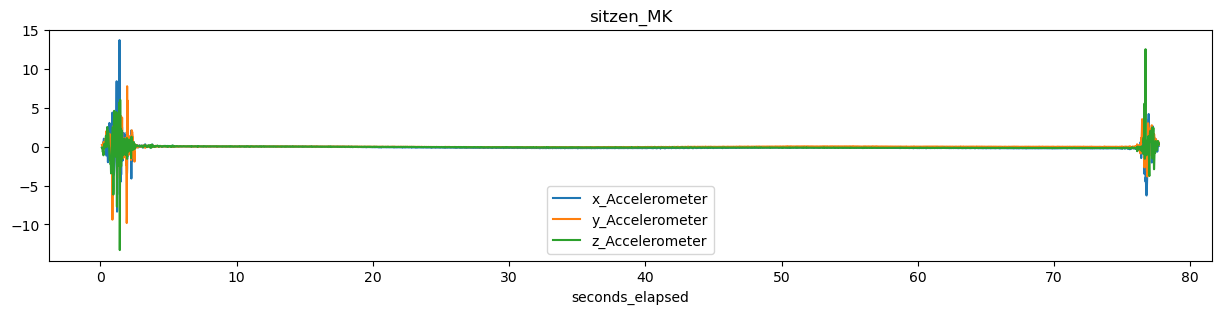

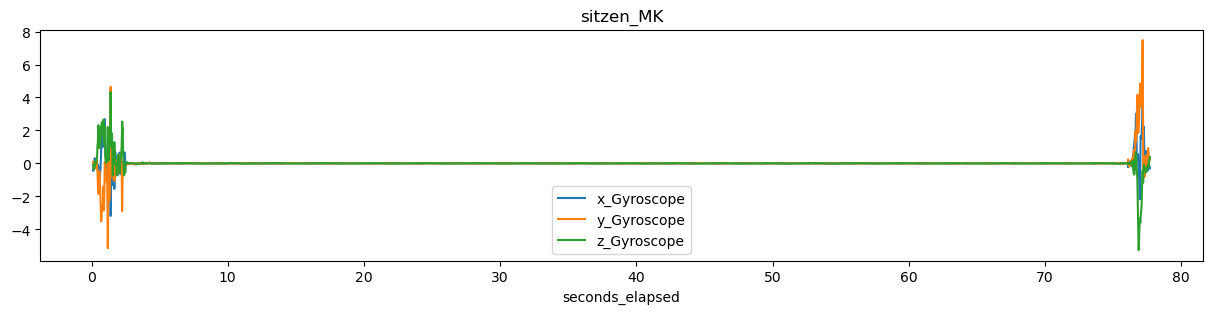

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
0.11                  16.300571      -11.001022      -44.908936   
0.12                  16.458340      -11.067688      -44.628708   
0.13                  16.464127      -10.965439      -44.663315   
0.14                  16.215769      -10.708878      -44.564392   
0.15                  16.481440      -10.529968      -44.501541   
...                         ...             ...             ...   
77.65                 24.815586      -22.998199      -37.460617   
77.66                 25.013100      -23.231354      -37.314346   
77.67                 25.232914      -23.171921      -36.968964   
77.68                 25.004442      -23.206009      -36.823822   
77.69                 25.127346      -23.105255      -36.641159   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
0.11                   -0.167943         0.220630        -0.126658   
0.12                   -0.205403         0.149870        -0.182914   
0.13                   -0.129338         0.157995        -0.188127   
0.14                   -0.064078         0.148494        -0.272795   
0.15                   -0.083532         0.114476        -0.435706   
...                          ...              ...              ...   
77.65                   0.395447         0.598275         0.420027   
77.66                   0.366658         0.664232         0.335214   
77.67                   0.381514         0.527120         0.209069   
77.68                   0.347564         0.305925         0.226604   
77.69                   0.091150         0.205427         0.418184   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
0.11               -0.442586     0.084677    -0.095899   0.050328  -5.148794   
0.12               -0.385956    -0.030379    -0.119308   0.058010  -5.114098   
0.13               -0.329737    -0.124809    -0.160602   0.058410  -5.084065   
0.14               -0.261898    -0.186065    -0.206688   0.054351  -5.059301   
0.15               -0.190452    -0.214171    -0.268229   0.049265  -5.040097   
...                      ...          ...          ...        ...        ...   
77.65              -0.188613     0.264137     0.201214   0.330595  -7.021469   
77.66              -0.175115     0.196888     0.254150   0.330504  -7.009764   
77.67              -0.178785     0.205615     0.317455   0.323878  -6.998796   
77.68              -0.234140     0.245675     0.347710   0.316078  -6.985898   
77.69              -0.308768     0.284577     0.380964   0.309131  -6.968448   

                 z_Gravity activity userID  
seconds_elapsed                             
0.11             -8.346123   sitzen     MK  
0.12             -8.367379   sitzen     MK  
0.13             -8.385658   sitzen     MK  
0.14             -8.400649   sitzen     MK  
0.15             -8.412216   sitzen     MK  
...                    ...      ...    ...  
77.65            -6.838133   sitzen     MK  
77.66            -6.850136   sitzen     MK  
77.67            -6.861657   sitzen     MK  
77.68            -6.875152   sitzen     MK  
77.69            -6.893153   sitzen     MK  

[7778 rows x 14 columns]

In [246]:
# iphone12 from Manjavy
sitz2 = read_json('../Daten/01_iPhone12-2023-03-16_10-57-54.json', 'sitzen', 'MK')
vis_all_sensors(sitz2)
sitz2

In [247]:
vis_all_sensors(time_win(sitz2,25,800))
time_win(sitz2,25,800)

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
25.00                -46.200806       18.220978        2.537735   
25.01                -46.167683       18.123215        2.342178   
25.02                -46.212814       18.038895        2.251099   
25.03                -46.116970       18.256454        2.144653   
25.04                -46.172138       18.030487        2.226532   
...                         ...             ...             ...   
32.93                -45.545986       18.364578        2.457390   
32.94                -45.357632       18.348221        2.844467   
32.95                -45.419807       18.377625        2.845909   
32.96                -45.563652       18.614868        2.629387   
32.97                -45.500198       18.744873        2.626656   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
25.00                  -0.120458        -0.045582        -0.055336   
25.01                  -0.115043        -0.045733        -0.064327   
25.02                  -0.123132        -0.047647        -0.066204   
25.03                  -0.118004        -0.050715        -0.059558   
25.04                  -0.121070        -0.054909        -0.060136   
...                          ...              ...              ...   
32.93                  -0.182246        -0.072095        -0.102881   
32.94                  -0.182953        -0.075674        -0.095329   
32.95                  -0.187551        -0.081546        -0.095517   
32.96                  -0.184443        -0.075237        -0.099736   
32.97                  -0.184125        -0.076975        -0.100792   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
25.00              -0.000104     0.001144     0.009413  -5.901407   5.296964   
25.01              -0.003272     0.002025     0.010632  -5.901138   5.297416   
25.02              -0.004467     0.003399     0.012444  -5.900830   5.297833   
25.03               0.000706     0.002134     0.013204  -5.900420   5.298355   
25.04              -0.003810     0.000232     0.012364  -5.899897   5.298959   
...                      ...          ...          ...        ...        ...   
32.93              -0.001834    -0.003122    -0.005130  -5.819720   5.317044   
32.94              -0.002287    -0.000316    -0.003822  -5.820058   5.316581   
32.95              -0.001317    -0.003278    -0.005252  -5.820248   5.316168   
32.96              -0.000333    -0.000959    -0.005058  -5.820513   5.315844   
32.97              -0.001473    -0.001172    -0.002940  -5.820682   5.315489   

                 z_Gravity activity userID  
seconds_elapsed                             
25.00             5.769397   sitzen     MK  
25.01             5.769261   sitzen     MK  
25.02             5.769192   sitzen     MK  
25.03             5.769129   sitzen     MK  
25.04             5.769109   sitzen     MK  
...                    ...      ...    ...  
32.93             5.833552   sitzen     MK  
32.94             5.833631   sitzen     MK  
32.95             5.833820   sitzen     MK  
32.96             5.833848   sitzen     MK  
32.97             5.834008   sitzen     MK  

[800 rows x 14 columns]

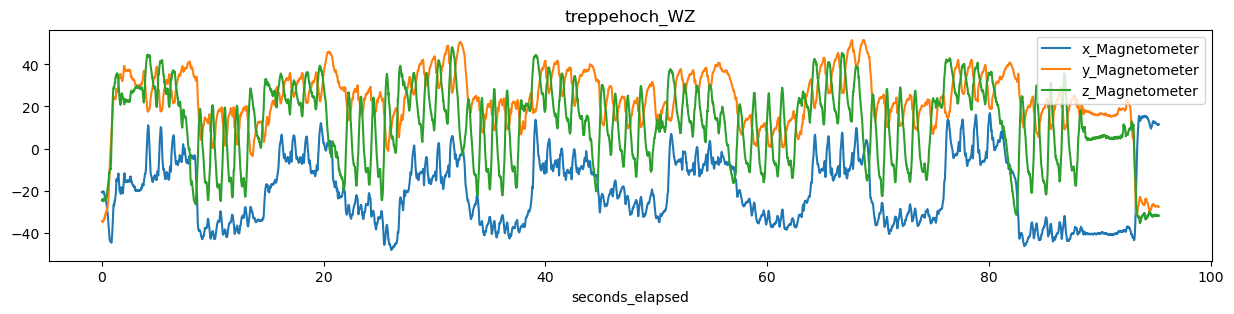

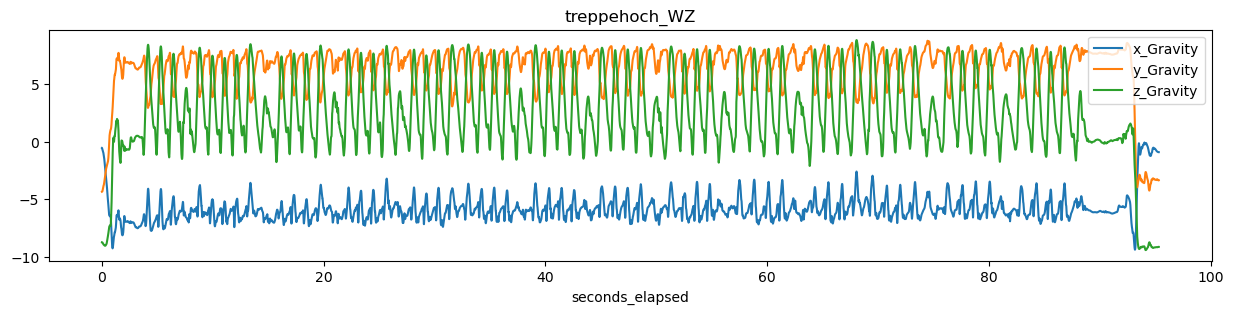

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
0.01                 -20.760803      -34.497086      -24.716125   
0.02                 -20.777512      -34.586258      -24.562378   
0.03                 -20.777405      -34.560272      -24.446449   
0.04                 -20.773697      -34.638565      -24.359344   
0.05                 -20.969452      -34.666626      -24.349693   
...                         ...             ...             ...   
95.26                 11.534119      -27.550171      -32.246170   
95.27                 11.464355      -27.716904      -31.987427   
95.28                 11.220581      -27.711212      -31.917801   
95.30                 11.297440      -27.798019      -32.037628   
95.31                 11.538681      -27.755539      -31.938751   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
0.01                   -0.284917         1.349194         0.987480   
0.02                   -0.559287         1.337920         1.023197   
0.03                   -0.698517         1.282627         1.259463   
0.04                   -0.842321         1.329152         1.527566   
0.05                   -0.991583         1.688993         1.887061   
...                          ...              ...              ...   
95.26                   0.042646        -0.014579         0.324123   
95.27                   0.064118         0.001747         0.476683   
95.28                   0.058543         0.019846         0.496046   
95.30                   0.073612         0.038311         0.436408   
95.31                  -0.027654         0.122070         0.348103   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
0.01               -0.139171    -0.160372    -0.398297  -0.562331  -4.366337   
0.02               -0.055056    -0.420168    -0.402181  -0.570177  -4.360001   
0.03               -0.032915    -0.634394    -0.384554  -0.600039  -4.359326   
0.04               -0.202466    -0.667332    -0.333750  -0.642683  -4.351532   
0.05               -0.359100    -0.637022    -0.411407  -0.684059  -4.328750   
...                      ...          ...          ...        ...        ...   
95.26               0.081475    -0.045307    -0.011158  -0.923712  -3.378304   
95.27               0.035143    -0.025864    -0.007997  -0.925881  -3.382360   
95.28              -0.016714    -0.018909     0.013601  -0.927338  -3.382203   
95.30              -0.057592     0.003573     0.003236  -0.927893  -3.378223   
95.31              -0.075034     0.008653    -0.015830  -0.926884  -3.372049   

                 z_Gravity    activity userID  
seconds_elapsed                                
0.01             -8.762949  treppehoch     WZ  
0.02             -8.765596  treppehoch     WZ  
0.03             -8.763938  treppehoch     WZ  
0.04             -8.764788  treppehoch     WZ  
0.05             -8.772934  treppehoch     WZ  
...                    ...         ...    ...  
95.26            -9.159924  treppehoch     WZ  
95.27            -9.158208  treppehoch     WZ  
95.28            -9.158118  treppehoch     WZ  
95.30            -9.159531  treppehoch     WZ  
95.31            -9.161908  treppehoch     WZ  

[9501 rows x 14 columns]

In [248]:
# iphone13 WZ
treppehoch = read_json('../Daten/treppehoch5-2023-03-12_12-13-06.json', 'treppehoch', 'WZ')
vis_all_sensors(treppehoch)
treppehoch

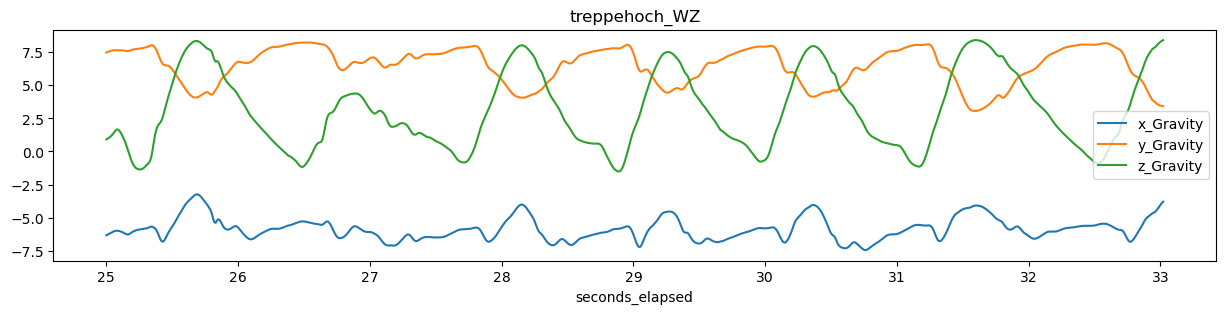

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
25.00                -33.005386       24.537025      -13.045792   
25.01                -33.047775       24.637428      -12.923927   
25.02                -32.894226       24.847816      -12.484215   
25.03                -32.986832       25.022354      -12.233902   
25.04                -32.844528       25.271515      -12.104362   
...                         ...             ...             ...   
32.98                -24.520401       25.636848       20.762768   
32.99                -24.882889       25.044617       21.539368   
33.00                -24.827759       24.353088       21.716644   
33.01                -24.649094       23.732452       22.068554   
33.02                -24.588013       23.347733       22.570694   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
25.00                   2.507300        -1.701358         1.034903   
25.01                   2.318988        -1.922900         1.231204   
25.02                   2.012231        -1.960384         1.156077   
25.03                   1.693455        -1.944414         1.091464   
25.04                   1.554676        -1.789675         1.432179   
...                          ...              ...              ...   
32.98                   1.087194        -0.306560        -3.868936   
32.99                   1.608157        -0.465681        -3.697135   
33.00                   2.230456        -0.494361        -3.593814   
33.01                   2.631902        -0.471464        -3.539137   
33.02                   2.774077        -0.537494        -3.540453   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
25.00              -0.188674    -0.527150     0.605953  -6.307497   7.453278   
25.01              -0.225959    -0.687077     0.640733  -6.255056   7.490618   
25.02              -0.223340    -0.871869     0.633915  -6.198941   7.528399   
25.03              -0.311339    -0.964279     0.588039  -6.142779   7.563455   
25.04              -0.533648    -1.040655     0.513532  -6.089294   7.592471   
...                      ...          ...          ...        ...        ...   
32.98               0.479420    -2.787738    -2.428086  -4.300063   3.536786   
32.99               0.612952    -2.740583    -2.228780  -4.156037   3.482824   
33.00               0.682929    -2.490776    -2.043165  -4.014585   3.448655   
33.01               0.751934    -2.228709    -1.895054  -3.885566   3.430698   
33.02               0.730076    -1.794198    -1.785502  -3.779492   3.422508   

                 z_Gravity    activity userID  
seconds_elapsed                                
25.00             0.913529  treppehoch     WZ  
25.01             0.967123  treppehoch     WZ  
25.02             1.032822  treppehoch     WZ  
25.03             1.109407  treppehoch     WZ  
25.04             1.202191  treppehoch     WZ  
...                    ...         ...    ...  
32.98             8.072856  treppehoch     WZ  
32.99             8.171150  treppehoch     WZ  
33.00             8.255922  treppehoch     WZ  
33.01             8.324847  treppehoch     WZ  
33.02             8.376891  treppehoch     WZ  

[800 rows x 14 columns]

In [249]:
vis_all_sensors(time_win(treppehoch,25,800))
time_win(treppehoch,25,800)

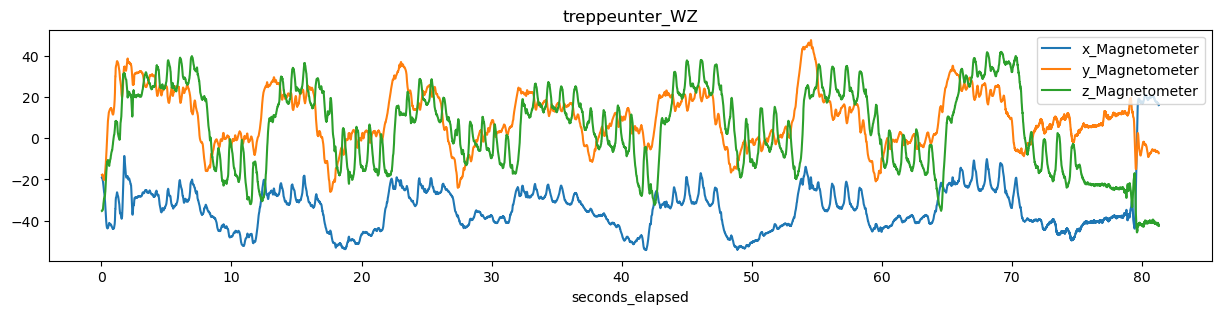

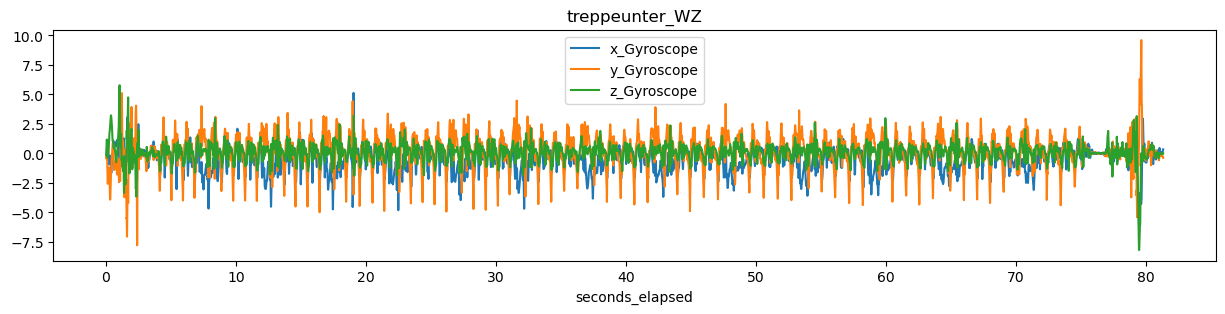

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
0.04                 -18.985336      -17.856705      -35.260071   
0.05                 -19.013565      -17.858170      -35.205986   
0.06                 -18.976578      -17.819260      -35.164894   
0.07                 -19.400085      -17.648514      -34.949875   
0.08                 -19.828888      -17.748230      -34.719360   
...                         ...             ...             ...   
81.26                 16.678452       -6.885025      -42.264450   
81.27                 16.712112       -6.812958      -41.819321   
81.28                 16.288193       -6.883133      -42.195045   
81.29                 16.255325       -6.900421      -41.651520   
81.30                 16.010986       -7.291489      -42.537483   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
0.04                   -2.260032         0.296822         1.044218   
0.05                   -1.846520         0.984769         0.731108   
0.06                   -1.067447         1.483522         0.651143   
0.07                   -0.180461         2.345240         0.727423   
0.08                    0.557262         2.930417         0.120598   
...                          ...              ...              ...   
81.26                  -0.004314        -0.025605        -0.124456   
81.27                   0.116552        -0.023045        -0.129342   
81.28                   0.113419         0.032564        -0.119318   
81.29                  -0.024288         0.026945        -0.254189   
81.30                  -0.024208         0.088878        -0.304649   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
0.04               -0.108539    -0.248255    -0.146506   0.232742  -3.457767   
0.05               -0.064892    -0.161162     0.066557   0.215919  -3.449899   
0.06                0.091771    -0.490359     0.570966   0.184136  -3.448713   
0.07                0.401696    -0.426990     1.138339   0.107437  -3.473059   
0.08                0.632273    -0.287120     1.171271   0.034405  -3.522083   
...                      ...          ...          ...        ...        ...   
81.26               0.117614    -0.278948    -0.014453  -0.775148  -4.427909   
81.27               0.150678    -0.325745    -0.038409  -0.800695  -4.438849   
81.28               0.216469    -0.368341    -0.053481  -0.828837  -4.453906   
81.29               0.282922    -0.392365    -0.041806  -0.860669  -4.474773   
81.30               0.336262    -0.389971    -0.007237  -0.895016  -4.501092   

                 z_Gravity     activity userID  
seconds_elapsed                                 
0.04             -9.173879  treppeunter     WZ  
0.05             -9.177252  treppeunter     WZ  
0.06             -9.178391  treppeunter     WZ  
0.07             -9.170425  treppeunter     WZ  
0.08             -9.152274  treppeunter     WZ  
...                    ...          ...    ...  
81.26            -8.715684  treppeunter     WZ  
81.27            -8.707806  treppeunter     WZ  
81.28            -8.697479  treppeunter     WZ  
81.29            -8.683665  treppeunter     WZ  
81.30            -8.666574  treppeunter     WZ  

[8101 rows x 14 columns]

In [250]:
# iphone 13 WZ
treppeunter = read_json('../Daten/treppeunter5-2023-03-12_11-20-57.json', 'treppeunter', 'WZ')
vis_all_sensors(treppeunter)
treppeunter

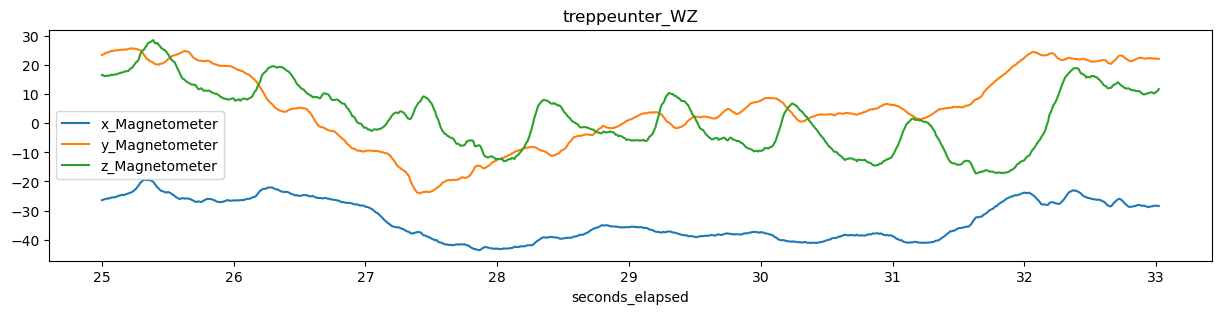

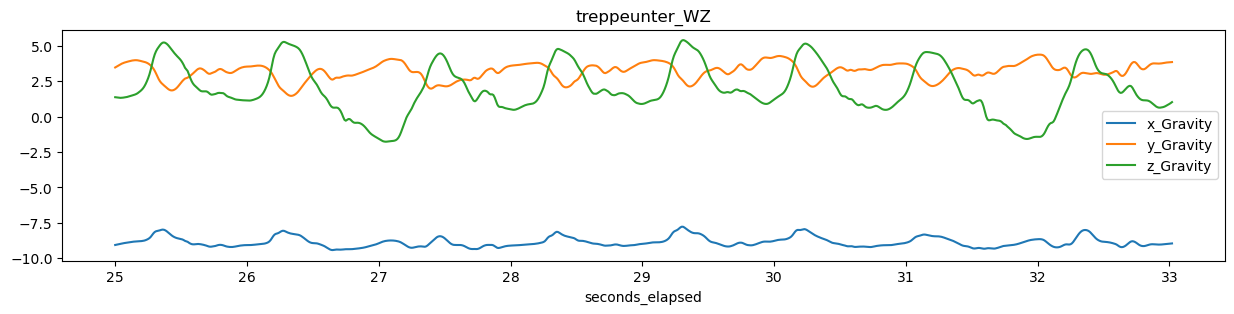

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
25.00                -26.457901       23.481796       16.527061   
25.01                -26.253677       23.585663       16.526573   
25.02                -26.084091       23.877678       16.104393   
25.03                -26.082199       24.186867       16.365128   
25.04                -25.819977       24.262627       16.239464   
...                         ...             ...             ...   
32.98                -28.385315       22.183868       10.280296   
32.99                -28.304550       22.109390       10.256386   
33.00                -28.362564       22.251427       10.771912   
33.01                -28.383987       22.114784       11.015579   
33.02                -28.435165       22.118423       11.717110   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
25.00                   0.901732         0.412046        -0.218969   
25.01                   1.550763         0.242084        -0.441990   
25.02                   2.185828        -0.011628        -0.232884   
25.03                   2.671689        -0.412618         0.205145   
25.04                   2.810366        -1.095124         0.519732   
...                          ...              ...              ...   
32.98                   1.364811        -1.449837         1.052284   
32.99                   1.460543        -1.617180         0.629710   
33.00                   1.718619        -1.708938         0.004889   
33.01                   2.050007        -1.902081        -0.078008   
33.02                   2.316360        -2.135102         0.424098   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
25.00               0.250805    -0.003126     0.511029  -9.070747   3.467458   
25.01               0.177497     0.087401     0.554476  -9.052694   3.518757   
25.02               0.074242     0.151828     0.608037  -9.033693   3.573153   
25.03              -0.032722     0.121426     0.637149  -9.013032   3.629977   
25.04              -0.119872     0.047763     0.617922  -8.990998   3.685949   
...                      ...          ...          ...        ...        ...   
32.98              -1.015454    -0.156359     0.195897  -8.998872   3.818152   
32.99              -1.031955    -0.163088     0.179003  -8.990456   3.826579   
33.00              -1.008521    -0.199970     0.173772  -8.982178   3.833492   
33.01              -0.972937    -0.297287     0.182576  -8.973141   3.840188   
33.02              -0.936125    -0.432635     0.213744  -8.961916   3.848453   

                 z_Gravity     activity userID  
seconds_elapsed                                 
25.00             1.366988  treppeunter     WZ  
25.01             1.355527  treppeunter     WZ  
25.02             1.339903  treppeunter     WZ  
25.03             1.326246  treppeunter     WZ  
25.04             1.321408  treppeunter     WZ  
...                    ...          ...    ...  
32.98             0.782572  treppeunter     WZ  
32.99             0.836289  treppeunter     WZ  
33.00             0.891740  treppeunter     WZ  
33.01             0.951891  treppeunter     WZ  
33.02             1.021702  treppeunter     WZ  

[800 rows x 14 columns]

In [251]:
vis_all_sensors(time_win(treppeunter,25,800))
time_win(treppeunter,25,800)

2. https://www.youtube.com/watch?v=lUI6VMj43PE
- convert long table to wide form: magnetometer_x, magnetometer_y, magnetometer_z,...
- select the 800 rows from 25th second for each record (to get balanced points of each record)
- use LabelEncoder to convert string labels to numeric labels
- put all records in one dataframe
- scale all features in X dataframe

In [252]:
test = pd.concat([time_win(sitz2,25,800),time_win(sitz,25,800),time_win(treppeunter,25,800),time_win(treppehoch,25,800)],axis=0)
test

x_Magnetometer  y_Magnetometer  z_Magnetometer  \
seconds_elapsed                                                   
25.00                -46.200806       18.220978        2.537735   
25.01                -46.167683       18.123215        2.342178   
25.02                -46.212814       18.038895        2.251099   
25.03                -46.116970       18.256454        2.144653   
25.04                -46.172138       18.030487        2.226532   
...                         ...             ...             ...   
32.98                -24.520401       25.636848       20.762768   
32.99                -24.882889       25.044617       21.539368   
33.00                -24.827759       24.353088       21.716644   
33.01                -24.649094       23.732452       22.068554   
33.02                -24.588013       23.347733       22.570694   

                 x_Accelerometer  y_Accelerometer  z_Accelerometer  \
seconds_elapsed                                                      
25.00                  -0.120458        -0.045582        -0.055336   
25.01                  -0.115043        -0.045733        -0.064327   
25.02                  -0.123132        -0.047647        -0.066204   
25.03                  -0.118004        -0.050715        -0.059558   
25.04                  -0.121070        -0.054909        -0.060136   
...                          ...              ...              ...   
32.98                   1.087194        -0.306560        -3.868936   
32.99                   1.608157        -0.465681        -3.697135   
33.00                   2.230456        -0.494361        -3.593814   
33.01                   2.631902        -0.471464        -3.539137   
33.02                   2.774077        -0.537494        -3.540453   

                 x_Gyroscope  y_Gyroscope  z_Gyroscope  x_Gravity  y_Gravity  \
seconds_elapsed                                                                
25.00              -0.000104     0.001144     0.009413  -5.901407   5.296964   
25.01              -0.003272     0.002025     0.010632  -5.901138   5.297416   
25.02              -0.004467     0.003399     0.012444  -5.900830   5.297833   
25.03               0.000706     0.002134     0.013204  -5.900420   5.298355   
25.04              -0.003810     0.000232     0.012364  -5.899897   5.298959   
...                      ...          ...          ...        ...        ...   
32.98               0.479420    -2.787738    -2.428086  -4.300063   3.536786   
32.99               0.612952    -2.740583    -2.228780  -4.156037   3.482824   
33.00               0.682929    -2.490776    -2.043165  -4.014585   3.448655   
33.01               0.751934    -2.228709    -1.895054  -3.885566   3.430698   
33.02               0.730076    -1.794198    -1.785502  -3.779492   3.422508   

                 z_Gravity    activity userID  
seconds_elapsed                                
25.00             5.769397      sitzen     MK  
25.01             5.769261      sitzen     MK  
25.02             5.769192      sitzen     MK  
25.03             5.769129      sitzen     MK  
25.04             5.769109      sitzen     MK  
...                    ...         ...    ...  
32.98             8.072856  treppehoch     WZ  
32.99             8.171150  treppehoch     WZ  
33.00             8.255922  treppehoch     WZ  
33.01             8.324847  treppehoch     WZ  
33.02             8.376891  treppehoch     WZ  

[3200 rows x 14 columns]

In [357]:

def df_to_tensor(min_time,n,df_lst):
    ''' select same rows and columns in each dataframe, 
    encode the activity to number,
    concatenate all dataframes to a tensor'''
    tensor_concat = torch.empty((0, 800, df_lst[0].shape[1]-2)) # generate an empty tensor to concate all arrays
    label_lst = []
    for df in df_lst:
        # append the unique label
        label_lst.append(df['activity'].unique()[0]) 
        # take n rows from the min_time seconds, drop the userID
        df = time_win(df,min_time,n).iloc[:,:-2] 
        # transform dataframe to numpy array
        array_ = df.to_numpy()
        tensor_concat = np.concatenate([tensor_concat, np.expand_dims(array_, 0)], axis=0)
        
        
    
    # encode the activity label to number
    le = LabelEncoder()
    le.fit(np.array(label_lst))
    label_ = le.transform(np.array(label_lst))
    
    return torch.tensor(tensor_concat),torch.tensor(label_)
    

In [358]:
df_lst = [sitz,sitz2,treppehoch,treppeunter]

result = df_to_tensor(25,800,df_lst)
tensor_X = result[0]
tensor_y = result[1]
tensor_.size(), label_.size(),label_

(torch.Size([4, 800, 12]), torch.Size([4]), tensor([0, 0, 1, 2]))

### split to train and test set

In [359]:
# assume tensor_x and tensor_y are numpy arrays
X_train, X_test, y_train, y_test = train_test_split(tensor_X, tensor_y, test_size=0.2, random_state=42)
X_train.size(), X_test.size(), y_train.size(), y_test.size()

(torch.Size([3, 800, 12]),
 torch.Size([1, 800, 12]),
 torch.Size([3]),
 torch.Size([1]))

#### stack 2 dim arrays to 3 dimension
tensor1 = np.stack([arr1, arr2],axis=0)
tensor2 = np.stack([arr3, arr4],axis=0)
tensor1.shape # (2, 800, 14)
#### concat two tensors
tensor4 = np.concatenate([tensor1, tensor2], axis=0)

3. split to train-test 7/3
https://www.kaggle.com/code/thitiwat/humanactivityrecognition-with-neural-networks#Reading-the-data

4. prepare train and test data, train_X, train_y, test_X, test_y
- code train_y, test_y to number 
    - le = LabelEncoder()
    - y_train = le.fit_transform(y_train)
    - y_test = le.fit_transform(y_test)
- scale train_X, test_X

use random forest
https://www.kaggle.com/code/srikariamrutham/randomforest-dataset